
🔍 Vista previa de la columna 'Eficacia' normalizada:
   Eficacia
0  0.252096
1  0.000000
2  0.167082
3  0.236303
4  0.000000

Valor mínimo: 0.0000 - Valor máximo: 1.0000

📋 Valores de 'Eficacia' normalizada para pacientes seleccionados:
      id  Eficacia
10    11  0.000000
19    20  0.475765
24    25  0.043301
26    27  0.000000
43    44  0.139997
245  246  0.260738

 PREDICCIÓN PARA NUEVO PACIENTE 

📋 Porcentaje de Recomendación:
- Erenumab: 32.00%
- Galcanezumab: 28.00%
- Amitriptilina: 14.00%
- Fremanezumab: 14.00%
- Topiramato: 12.00%
- Propranolol: 0.00%

💊 Fármaco más recomendado: Erenumab (32.00% de probabilidad)
Importante:
Siguiendo las indicaciones de la Sociedad Española de Neurología 
queda restringido el uso de Anticuerpos Monoclonales a pacientes que hayan
sufrido tres fracasos a tratamientos preventivos, incluyendo
OnabotulinumtoxinA en caso de migraña crónica.

 EVALUACIÓN DEL MODELO 

📊 Métricas de Evaluación:
Exactitud (Accuracy): 0.8625
Recall Promedio: 0.8625
F1-S

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


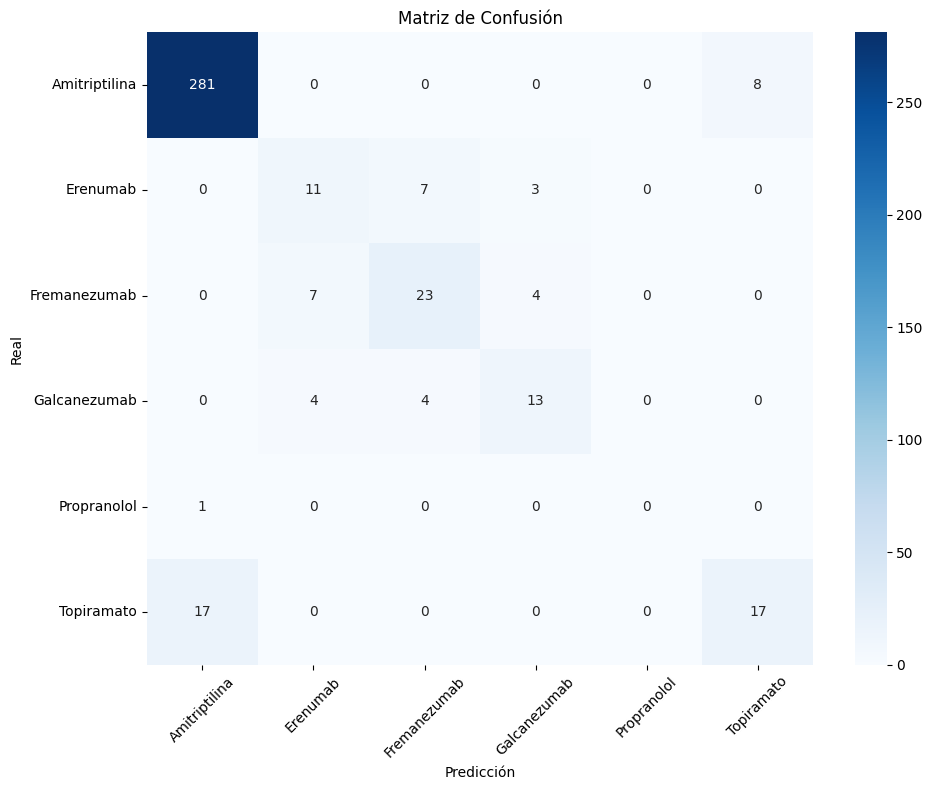

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar los datos
file_path = "test_modificado_agrupacion_gravedad.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# ✅ Normalizar la variable 'Eficacia' entre 0 y 1
df["Eficacia"] = (df["Eficacia"] - df["Eficacia"].min()) / (df["Eficacia"].max() - df["Eficacia"].min())

# 👀 Verificar la normalización
print("\n🔍 Vista previa de la columna 'Eficacia' normalizada:")
print(df[["Eficacia"]].head())
print(f"\nValor mínimo: {df['Eficacia'].min():.4f} - Valor máximo: {df['Eficacia'].max():.4f}")

# 🔎 IDs de pacientes que quieres inspeccionar
ids_a_mostrar = [11, 20, 25, 27, 44, 246]

# 👀 Mostrar los valores de 'Eficacia' para esos IDs
print("\n📋 Valores de 'Eficacia' normalizada para pacientes seleccionados:")
print(df[df["id"].isin(ids_a_mostrar)][["id", "Eficacia"]].sort_values(by="id"))


# 🎯 Seleccionar características y la variable objetivo
features = ["edad", "IMC_categorica", "genero", "Eficacia", "Adherencia", "Gravedad Total"]
features += [col for col in df.columns if col.startswith("Comorbilidad_") or col.startswith("EA_")]

# Convertir variables categóricas a numéricas
label_encoder_farmaco = LabelEncoder()
df["farmaco"] = label_encoder_farmaco.fit_transform(df["farmaco"])
farmacos_nombres = label_encoder_farmaco.classes_  # Guardar nombres originales

# Convertir género a numérico
df["genero"] = df["genero"].map({"Femenino": 0, "Masculino": 1})

# 📌 Definir X (características) e y (fármaco a predecir)
X = df[features]
y = df["farmaco"]

# 🧪 Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌳 Entrenar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
model.fit(X_train, y_train)

# 📊 Evaluar el modelo
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    y_pred = modelo.predict(X_test)

    print("\n📊 Métricas de Evaluación:")
    print("="*50)
    print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print(f"Recall Promedio: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score Promedio: {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\n📝 Reporte de Clasificación:")
    print("="*50)
    print(classification_report(y_test, y_pred, target_names=nombres_clases))

    print("\n🔢 Matriz de Confusión:")
    matriz = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases,
                yticklabels=nombres_clases)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🔍 Función para predecir el mejor fármaco
def predecir_mejor_farmaco(nuevo_paciente):
    input_data = pd.DataFrame([nuevo_paciente])

    for col in features:
        if col not in input_data:
            input_data[col] = 0

    probabilidades = model.predict_proba(input_data[features])[0]
    farmacos = label_encoder_farmaco.inverse_transform(range(len(probabilidades)))

    resultados = sorted(zip(farmacos, probabilidades), key=lambda x: x[1], reverse=True)

    print("\n📋 Porcentaje de Recomendación:")
    for farmaco, prob in resultados:
        print(f"- {farmaco}: {prob*100:.2f}%")

    return resultados[0][0], resultados[0][1]

# 👩⚕️ Ejemplo de nuevo paciente
print("\n" + "="*50)
print(" PREDICCIÓN PARA NUEVO PACIENTE ")
print("="*50)

# introducimos un paciente que sabemos que a priori no puede dar de primera opción la amitriptilina.
nuevo_paciente = {
    "edad": 55,
    "IMC_categorica": 3,  # Sobrepeso
    "genero": "Hombre",
    "Eficacia": 1,
    "Adherencia": 1,
    "Gravedad Total": 0,

    # Comorbilidades
    "Comorbilidad_Trastorno bipolar": 1,
    "Comorbilidad_Ansiedad": 0,
    "Comorbilidad_Insomnio": 0,
}

# Inicializar valores faltantes
for col in features:
    if col.startswith("EA_") and col not in nuevo_paciente:
        nuevo_paciente[col] = 0

nuevo_paciente["genero"] = 0  # Femenino

# Realizar predicción
mejor_farmaco, prob = predecir_mejor_farmaco(nuevo_paciente)
print(f"\n💊 Fármaco más recomendado: {mejor_farmaco} ({prob*100:.2f}% de probabilidad)")
print("="*50)
print('Importante:')
print('Siguiendo las indicaciones de la Sociedad Española de Neurología ')
print('queda restringido el uso de Anticuerpos Monoclonales a pacientes que hayan')
print('sufrido tres fracasos a tratamientos preventivos, incluyendo')
print('OnabotulinumtoxinA en caso de migraña crónica.')

# 📈 Evaluación del modelo
print("\n" + "="*50)
print(" EVALUACIÓN DEL MODELO ")
print("="*50)
evaluar_modelo(model, X_test, y_test, farmacos_nombres)

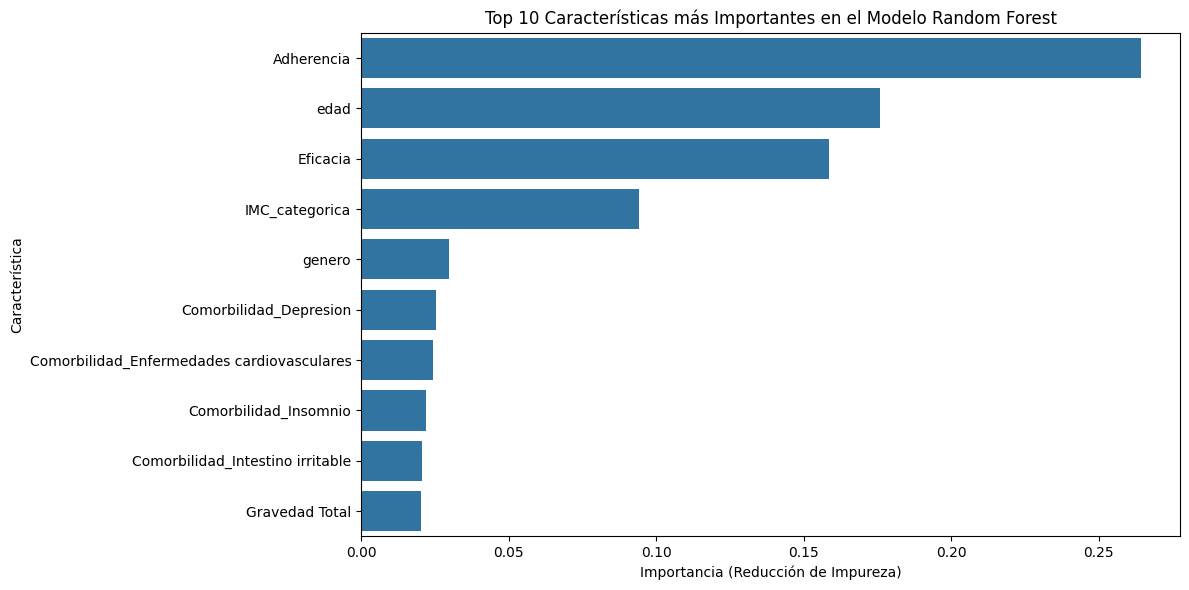


📊 Top 10 Ranking de Importancia de Características:
                                Característica  Importancia
4                                   Adherencia     0.264346
0                                         edad     0.175768
3                                     Eficacia     0.158514
1                               IMC_categorica     0.094148
2                                       genero     0.029813
6                       Comorbilidad_Depresion     0.025250
11  Comorbilidad_Enfermedades cardiovasculares     0.024365
9                        Comorbilidad_Insomnio     0.022048
10            Comorbilidad_Intestino irritable     0.020636
5                               Gravedad Total     0.020479


In [7]:
# Obtener importancia de características
importancias = model.feature_importances_
indices = np.argsort(importancias)[::-1]

# Crear DataFrame para mejor visualización
df_importancia = pd.DataFrame({
    'Característica': features,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

# # Visualización
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Importancia', y='Característica', data=df_importancia)
# plt.title('Importancia de Características en el Modelo Random Forest')
# plt.xlabel('Importancia (Reducción de Impureza)')
# plt.ylabel('Característica')
# plt.tight_layout()
# plt.show()

# # Mostrar tabla ordenada
# print("\n📊 Ranking de Importancia de Características:")
# print(df_importancia)

# Obtener las 10 características más importantes
# top_10 = df_importancia.sort_values('Importancia', ascending=False).head(10)
top_10 = df_importancia.head(10)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x='Importancia', y='Característica', data=top_10)
plt.title('Top 10 Características más Importantes en el Modelo Random Forest')
plt.xlabel('Importancia (Reducción de Impureza)')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Mostrar tabla ordenada
print("\n📊 Top 10 Ranking de Importancia de Características:")
print(top_10)


🔍 Vista previa de la columna 'Eficacia' normalizada:
   Eficacia
0  0.252096
1  0.000000
2  0.167082
3  0.236303
4  0.000000

Valor mínimo: 0.0000 - Valor máximo: 1.0000

 PREDICCIÓN PARA NUEVOS PACIENTES 

✅ Resultados guardados en: prediccion_asignacion_farmacos_agrupadosporgravedad.xlsx

🔍 Resumen de predicciones:
      Paciente_ID Farmaco_Recomendado  Probabilidad_Recomendado
0               1       Amitriptilina                      0.32
1               2        Fremanezumab                      0.42
2               3        Galcanezumab                      0.54
3               4        Fremanezumab                      0.48
4               5        Fremanezumab                      0.40
...           ...                 ...                       ...
1995         1996        Galcanezumab                      0.47
1996         1997            Erenumab                      0.39
1997         1998        Fremanezumab                      0.39
1998         1999            Erenumab   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


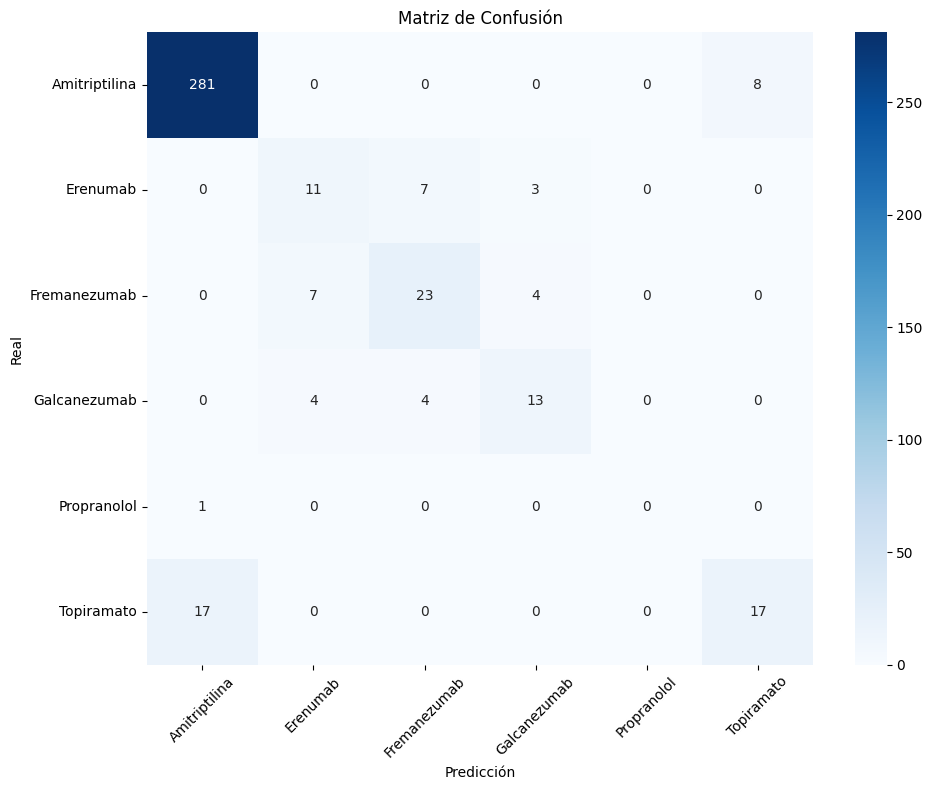

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Cargar los datos de entrenamiento
train_file_path = "test_modificado_agrupacion_gravedad.xlsx"
df = pd.read_excel(train_file_path, sheet_name="Sheet1")

# ✅ Normalizar la variable 'Eficacia' entre 0 y 1
df["Eficacia"] = (df["Eficacia"] - df["Eficacia"].min()) / (df["Eficacia"].max() - df["Eficacia"].min())

# 👀 Verificar la normalización
print("\n🔍 Vista previa de la columna 'Eficacia' normalizada:")
print(df[["Eficacia"]].head())
print(f"\nValor mínimo: {df['Eficacia'].min():.4f} - Valor máximo: {df['Eficacia'].max():.4f}")

# 🎯 Seleccionar características y la variable objetivo
features = ["edad", "IMC_categorica", "genero", "Eficacia", "Adherencia", "Gravedad Total"]
features += [col for col in df.columns if col.startswith("Comorbilidad_") or col.startswith("EA_")]

# Convertir variables categóricas a numéricas
label_encoder_farmaco = LabelEncoder()
df["farmaco"] = label_encoder_farmaco.fit_transform(df["farmaco"])
farmacos_nombres = label_encoder_farmaco.classes_  # Guardar nombres originales

# Convertir género a numérico
df["genero"] = df["genero"].map({"Femenino": 0, "Masculino": 1})

# 📌 Definir X (características) e y (fármaco a predecir)
X = df[features]
y = df["farmaco"]

# � Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌳 Entrenar el modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
model.fit(X_train, y_train)

# 📊 Evaluar el modelo (función se mantiene igual)
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    y_pred = modelo.predict(X_test)

    print("\n📊 Métricas de Evaluación:")
    print("="*50)
    print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print(f"Recall Promedio: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score Promedio: {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\n📝 Reporte de Clasificación:")
    print("="*50)
    print(classification_report(y_test, y_pred, target_names=nombres_clases))

    print("\n🔢 Matriz de Confusión:")
    matriz = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases,
                yticklabels=nombres_clases)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🔍 Función para predecir y guardar resultados
def predecir_y_guardar_resultados(pacientes_df, features, model, label_encoder):
    resultados = []

    for idx, paciente in pacientes_df.iterrows():
        # Preparar datos del paciente
        paciente_data = paciente.to_dict()
        paciente_data = {k: 0 if pd.isna(v) else v for k, v in paciente_data.items()}

        # Convertir género si es necesario
        if 'genero' in paciente_data and isinstance(paciente_data['genero'], str):
            paciente_data['genero'] = 0 if paciente_data['genero'].lower() == "femenino" else 1

        # Asegurar que todas las features estén presentes
        input_data = pd.DataFrame([paciente_data])
        for col in features:
            if col not in input_data:
                input_data[col] = 0

        # Obtener predicciones
        probabilidades = model.predict_proba(input_data[features])[0]
        farmacos = label_encoder.inverse_transform(range(len(probabilidades)))

        # Ordenar resultados
        farmacos_probs = sorted(zip(farmacos, probabilidades), key=lambda x: x[1], reverse=True)

        # Crear entrada para el DataFrame de resultados
        resultado_paciente = {
            'Paciente_ID': idx + 1,
            'Farmaco_Recomendado': farmacos_probs[0][0],
            'Probabilidad_Recomendado': farmacos_probs[0][1],
        }

        # Añadir todas las probabilidades
        for i, (farmaco, prob) in enumerate(farmacos_probs):
            resultado_paciente[f'Farmaco_{i+1}'] = farmaco
            resultado_paciente[f'Probabilidad_{i+1}'] = prob

        # Añadir características del paciente para referencia
        for feature in ['edad', 'genero', 'IMC_categorica', 'Eficacia', 'Adherencia', 'Gravedad Total']:
            if feature in paciente_data:
                resultado_paciente[feature] = paciente_data[feature]

        resultados.append(resultado_paciente)

    # Crear DataFrame de resultados
    resultados_df = pd.DataFrame(resultados)

    # Reordenar columnas
    column_order = ['Paciente_ID', 'Farmaco_Recomendado', 'Probabilidad_Recomendado']
    for i in range(1, len(farmacos_nombres)+1):
        column_order.extend([f'Farmaco_{i}', f'Probabilidad_{i}'])
    column_order.extend(['edad', 'genero', 'IMC_categorica', 'Eficacia', 'Adherencia', 'Gravedad Total'])

    # Seleccionar solo las columnas que existen
    column_order = [col for col in column_order if col in resultados_df.columns]
    resultados_df = resultados_df[column_order]

    # Guardar resultados en Excel
    output_file = "prediccion_asignacion_farmacos_agrupadosporgravedad.xlsx"
    resultados_df.to_excel(output_file, index=False)
    print(f"\n✅ Resultados guardados en: {output_file}")

    return resultados_df

# 👩⚕️ Cargar y procesar nuevos pacientes
print("\n" + "="*50)
print(" PREDICCIÓN PARA NUEVOS PACIENTES ")
print("="*50)

# Cargar el archivo con nuevos pacientes
new_patients_file = "test_modificado_versionvalidacion.xlsx"
try:
    new_patients_df = pd.read_excel(new_patients_file, sheet_name="Sheet1")

    # Realizar predicciones y guardar resultados
    resultados = predecir_y_guardar_resultados(
        pacientes_df=new_patients_df,
        features=features,
        model=model,
        label_encoder=label_encoder_farmaco
    )

    # Mostrar resumen por consola
    print("\n🔍 Resumen de predicciones:")
    print(resultados[['Paciente_ID', 'Farmaco_Recomendado', 'Probabilidad_Recomendado']])

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {new_patients_file}")
    print("Asegúrate de que el archivo esté en el directorio correcto y con el nombre especificado.")

# 📈 Evaluación del modelo
print("\n" + "="*50)
print(" EVALUACIÓN DEL MODELO ")
print("="*50)
evaluar_modelo(model, X_test, y_test, farmacos_nombres)